In [97]:
import csv
import numpy as np
import pandas as pd
import timeit
from math import sqrt
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# data sets converted to dataframe using "pd.read_table" method

df_dssp_info = pd.read_table("dssp_info.txt", delim_whitespace=True, 
                             names= ('PDB_code', 'PDB_chain_code', 'PDB_seq_code', 'residue_name', 'secondary_structure'))

df_stride_info = pd.read_table("stride_info.txt", delim_whitespace=True, 
                               names= ('PDB_code', 'PDB_chain_code', 'PDB_seq_code', 'residue_name', 'secondary_structure'))

df_cath_info = pd.read_table("cath_info.txt", delim_whitespace=True, 
                             names= ('PDB_code', 'PDB_chain_code', 'protein_family'))

In [3]:
# dataset modifications

# replacing 3-letter amino acids and other-secondary-structure with 1-letter ones and coil, respectively
ndf_dssp_info = df_dssp_info.replace({'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C', 'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'VAL': 'V',
'ILE': 'I', 'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'Other': 'Coil'})

ndf_stride_info = df_stride_info.replace({'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C', 'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'VAL': 'V',
'ILE': 'I', 'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'Other': 'Coil'})

# removing the non-natural amino acids from dataframes
list_natural_aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'V', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y']
modified_df_dssp_info = ndf_dssp_info.drop(ndf_dssp_info[ndf_dssp_info.residue_name.isin(list_natural_aminoacids) == False].index)
modified_df_stride_info = ndf_stride_info.drop(ndf_stride_info[ndf_stride_info.residue_name.isin(list_natural_aminoacids) == False].index)
display(modified_df_dssp_info.head(), modified_df_stride_info.head())

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure
0,1w0n,A,12,I,Coil
1,1w0n,A,13,T,Beta
2,1w0n,A,14,K,Beta
3,1w0n,A,15,V,Beta
4,1w0n,A,16,E,Beta


,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure
0,1w0n,A,12,I,Coil
1,1w0n,A,13,T,Beta
2,1w0n,A,14,K,Beta
3,1w0n,A,15,V,Beta
4,1w0n,A,16,E,Beta


In [4]:
# the requirements for self-information calculations 

# the total number of residues in the two datasets (fs + fn-s)
nr_residues_dssp = len(modified_df_dssp_info.index)
nr_residues_stride = len(modified_df_stride_info.index)

# the total number of heix, beta, and coil for dssp & stride (fs)
fs_helix_dssp = len(modified_df_dssp_info[modified_df_dssp_info['secondary_structure'] == 'Helix'])
fs_beta_dssp = len(modified_df_dssp_info[modified_df_dssp_info['secondary_structure'] == 'Beta'])
fs_coil_dssp = len(modified_df_dssp_info[modified_df_dssp_info['secondary_structure'] == 'Coil'])

fs_helix_stride = len(modified_df_stride_info[modified_df_stride_info['secondary_structure'] == 'Helix'])
fs_beta_stride = len(modified_df_stride_info[modified_df_stride_info['secondary_structure'] == 'Beta'])
fs_coil_stride = len(modified_df_stride_info[modified_df_stride_info['secondary_structure'] == 'Coil'])

# function to count "fs,R"
def fs_R(dataset, amino_acid):
    helix = len(dataset[(dataset['residue_name'] == amino_acid) & (dataset['secondary_structure'] == 'Helix')])
    beta = len(dataset[(dataset['residue_name'] == amino_acid) & (dataset['secondary_structure'] == 'Beta')])
    coil = len(dataset[(dataset['residue_name'] == amino_acid) & (dataset['secondary_structure'] == 'Coil')])
    return helix, beta, coil

# dictionary for the both datasets, dssp and stride, contaning fs,R and fn-s,R for each amino acid (aa)
dict_fsR_dssp = {aa: {'H': {'fs,R': fs_R(modified_df_dssp_info, aa)[0], 'fn-s,R': fs_R(modified_df_dssp_info, aa)[1] + fs_R(modified_df_dssp_info, aa)[2]},
                      'E': {'fs,R': fs_R(modified_df_dssp_info, aa)[1], 'fn-s,R': fs_R(modified_df_dssp_info, aa)[0] + fs_R(modified_df_dssp_info, aa)[2]},
                      'C': {'fs,R': fs_R(modified_df_dssp_info, aa)[2], 'fn-s,R': fs_R(modified_df_dssp_info, aa)[0] + fs_R(modified_df_dssp_info, aa)[1]}}
                      for aa in list_natural_aminoacids}
dict_fsR_stride = {aa: {'H': {'fs,R': fs_R(modified_df_stride_info, aa)[0], 'fn-s,R': fs_R(modified_df_stride_info, aa)[1] + fs_R(modified_df_stride_info, aa)[2]},
                        'E': {'fs,R': fs_R(modified_df_stride_info, aa)[1], 'fn-s,R': fs_R(modified_df_stride_info, aa)[0] + fs_R(modified_df_stride_info, aa)[2]},
                        'C': {'fs,R': fs_R(modified_df_stride_info, aa)[2], 'fn-s,R': fs_R(modified_df_stride_info, aa)[0] + fs_R(modified_df_stride_info, aa)[1]}}
                        for aa in list_natural_aminoacids}

# dataframe for the both datasets, dssp and stride, contaning fs,R and fn-s,R for each amino acid (aa)
df_fsR_dssp = pd.DataFrame.from_dict({(i,j): dict_fsR_dssp[i][j] for i in dict_fsR_dssp.keys() for j in dict_fsR_dssp[i].keys()}, orient='index')
df_fsR_stride = pd.DataFrame.from_dict({(i,j): dict_fsR_stride[i][j] for i in dict_fsR_stride.keys() for j in dict_fsR_stride[i].keys()}, orient='index')

# calculating the constant value of self-information relation for each secondary structure of datasets (log(fn-s/fs))
consH_self_dssp = np.log((nr_residues_dssp - fs_helix_dssp)/fs_helix_dssp)
consE_self_dssp = np.log((nr_residues_dssp - fs_beta_dssp)/fs_beta_dssp)
consC_self_dssp = np.log((nr_residues_dssp - fs_coil_dssp)/fs_coil_dssp)
list_constants_dssp = [consH_self_dssp,consE_self_dssp,consC_self_dssp] * 20

consH_self_stride = np.log((nr_residues_stride - fs_helix_stride)/fs_helix_stride)
consE_self_stride = np.log((nr_residues_stride - fs_beta_stride)/fs_beta_stride)
consC_self_stride = np.log((nr_residues_stride - fs_coil_stride)/fs_coil_stride)
list_constants_stride = [consH_self_stride,consE_self_stride,consC_self_stride] * 20

# add a column named "const_self" to the dataframes "df_fsR_dssp" and "df_fsR_stride", containing the constant value of self-information relation
df_fsR_dssp = df_fsR_dssp.assign(const_self = list_constants_dssp)
df_fsR_stride = df_fsR_stride.assign(const_self = list_constants_stride)


In [5]:
# self-information calculations for each and every residue (R) of the two datasets (I(Sj;Rj))

# add the self-information column in the dataframes, "df_fsR_dssp" and "df_fsR_stride"
df_fsR_dssp['I'] = np.log(df_fsR_dssp['fs,R']/df_fsR_dssp['fn-s,R']) + df_fsR_dssp['const_self']
df_fsR_stride['I'] = np.log(df_fsR_stride['fs,R']/df_fsR_stride['fn-s,R']) + df_fsR_stride['const_self']

# add a column called "const_pair" in the dataframes, "df_fsR_dssp" and "df_fsR_stride",
# which is ln(fn-s,R/fs,R), used in pair-information calculations
df_fsR_dssp['const_pair'] = np.log(df_fsR_dssp['fn-s,R']/df_fsR_dssp['fs,R'])
df_fsR_stride['const_pair'] = np.log(df_fsR_stride['fn-s,R']/df_fsR_stride['fs,R'])

display(df_fsR_dssp.head(), df_fsR_stride.head())

fs,R  fn-s,R  const_self         I  const_pair
A H  2896    3065    0.609305  0.552588    0.056717
  E   984    4977    1.252107 -0.368849    1.620957
  C  2081    3880    0.300454 -0.322533    0.622987
R H  1531    2134    0.609305  0.277228    0.332077
  E   734    2931    1.252107 -0.132483    1.384590

fs,R  fn-s,R  const_self         I  const_pair
A H  2992    2971    0.565076  0.572119   -0.007043
  E  1007    4956    1.224172 -0.369451    1.593623
  C  1964    3999    0.362217 -0.348844    0.711061
R H  1586    2079    0.565076  0.294404    0.270672
  E   742    2923    1.224172 -0.146844    1.371017

In [6]:
# reset the row indexes of the dataframes, "modified_df_dssp_info" and "modified_df_stride_info"
modified_df_dssp_info = modified_df_dssp_info.reset_index(drop=True)
modified_df_stride_info = modified_df_stride_info.reset_index(drop=True)

In [7]:
# the requirements for pair-information calculations 

# function to count "fSj,Rj+m,Rj"
def freq_pair(dataset, aa_j, m, aa_m, SS): # dataset = dssp or stride, aa_j = central amino acide, m = (-8,8) excluding zero
    freq = 0                               # aa_m = amino acid in position j+m, SS = Helix, Beta, or Coil
    modified_dataset = dataset.drop(dataset.index[:8]) # delete the first 8 rows from dataset
    modified_dataset = modified_dataset.drop(modified_dataset.index[-8:]) # delete the last 8 rows from dataset
    list_index_aa_j = modified_dataset.index[(modified_dataset['residue_name'] == aa_j) & # creating a list of central amino acid indexes which has SS
                                             (modified_dataset['secondary_structure'] == SS)].tolist() 
    for idx in list_index_aa_j:
        if (dataset.iloc[idx + m][3] == aa_m):
            freq += 1
    return freq
#print(freq_pair(modified_df_dssp_info, 'N', -3, 'T', 'Coil'))

# dictionary for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Helix" secondary structure
start = timeit.default_timer()
dict_fsRR_dssp_H = {aa_j: {aa_m: {'j-8':freq_pair(modified_df_dssp_info, aa_j, -8, aa_m, 'Helix'), 'j-7':freq_pair(modified_df_dssp_info, aa_j, -7, aa_m, 'Helix'),
                                  'j-6':freq_pair(modified_df_dssp_info, aa_j, -6, aa_m, 'Helix'), 'j-5':freq_pair(modified_df_dssp_info, aa_j, -5, aa_m, 'Helix'),
                                  'j-4':freq_pair(modified_df_dssp_info, aa_j, -4, aa_m, 'Helix'), 'j-3':freq_pair(modified_df_dssp_info, aa_j, -3, aa_m, 'Helix'),
                                  'j-2':freq_pair(modified_df_dssp_info, aa_j, -2, aa_m, 'Helix'), 'j-1':freq_pair(modified_df_dssp_info, aa_j, -1, aa_m, 'Helix'),
                                  'j+1':freq_pair(modified_df_dssp_info, aa_j, +1, aa_m, 'Helix'), 'j+2':freq_pair(modified_df_dssp_info, aa_j, +2, aa_m, 'Helix'),
                                  'j+3':freq_pair(modified_df_dssp_info, aa_j, +3, aa_m, 'Helix'), 'j+4':freq_pair(modified_df_dssp_info, aa_j, +4, aa_m, 'Helix'),
                                  'j+5':freq_pair(modified_df_dssp_info, aa_j, +5, aa_m, 'Helix'), 'j+6':freq_pair(modified_df_dssp_info, aa_j, +6, aa_m, 'Helix'),
                                  'j+7':freq_pair(modified_df_dssp_info, aa_j, +7, aa_m, 'Helix'), 'j+8':freq_pair(modified_df_dssp_info, aa_j, +8, aa_m, 'Helix')}
                                   for aa_m in list_natural_aminoacids} 
                                   for aa_j in list_natural_aminoacids} 

# dataframe for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Helix" secondary structure
df_fsRR_dssp_H = pd.DataFrame.from_dict({(i,j): dict_fsRR_dssp_H[i][j] for i in dict_fsRR_dssp_H.keys() for j in dict_fsRR_dssp_H[i].keys()}, orient='index')
display(df_fsRR_dssp_H.head())
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

j-8  j-7  j-6  j-5  j-4  j-3  j-2  j-1  j+1  j+2  j+3  j+4  j+5  j+6  \
A A  296  321  272  313  374  335  331  339  369  362  346  402  312  289   
  R  147  147  130  156  170  151  172  166  187  202  170  178  188  181   
  N  119  123  116  130  116   95  120  112  103  127  105   97  138  119   
  D  173  183  188  201  206  175  184  186  140  148  159  136  144  170   
  C   25   28   29   22   28   24   25   23   30   26   28   29   22   26   

     j+7  j+8  
A A  329  302  
  R  156  170  
  N  108  103  
  D  167  159  
  C   21   18

Time (min):  11.759144323333334


In [10]:
# dataframe for dssp dataset containing "ln(fsj,Rj+m,Rj/ fn-sj,Rj+m,Rj)" for 16 positions from j-8 to j+8 and "Helix"
df_pairInfo_dssp_H = np.log(df_fsRR_dssp_H.loc[pd.IndexSlice[:, :], :]/
                           (df_fsRR_dssp_E.loc[pd.IndexSlice[:, :], :] +
                            df_fsRR_dssp_C.loc[pd.IndexSlice[:, :], :]))
display(df_pairInfo_dssp_H.head())

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.087293  0.101560 -0.091291  0.181683  0.435318  0.230634  0.149629   
  R -0.121555 -0.127561 -0.244453  0.000000  0.092373 -0.064125  0.143548   
  N -0.111226 -0.100471 -0.270290 -0.074108 -0.082692 -0.274437 -0.040822   
  D -0.017192  0.091492  0.043485  0.110348  0.358063  0.083382  0.121186   
  C  0.000000  0.036368  0.148420 -0.342945 -0.035091 -0.377294 -0.336472   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A  0.265318  0.472717  0.354310  0.305175  0.630476  0.174659  0.028072   
  R  0.149143  0.247502  0.616920  0.165985  0.269129  0.432421  0.110901   
  N -0.265108 -0.348878 -0.068468 -0.221237 -0.402023  0.067441  0.000000   
  D -0.102129 -0.500775 -0.195745 -0.135102 -0.360345 -0.328504 -0.028988   
  C -0.231802 -0.154151 -0.037740  0.387766  0.322773 -0.087011 -0.109199   

          j+7       j+8  
A A  0.154151 -0.048475  
  R -0.037740  0.237959  
  N -0.138150 -0.277926  
  D -0.102362  0.025479  
  C -0.046520 -0.476924

In [11]:
# add a column to dataframe "df_pairInfo_dssp_H" containing the second term of pair-information relation
# which is constant for each central amino acid of each secondary structure,
# obtained from the column "const_pair" of the dataframe "df_fsR_dssp" 
df_const_pair_dssp = df_fsR_dssp[['const_pair']]
modified_df_const_pair_dssp = df_const_pair_dssp.iloc[np.repeat(np.arange(len(df_const_pair_dssp)), 20)]
df_pairInfo_dssp_H['const_pair'] = modified_df_const_pair_dssp.loc[pd.IndexSlice[:, ['H']], :].values
df_pairInfo_dssp_H.head()

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.087293  0.101560 -0.091291  0.181683  0.435318  0.230634  0.149629   
  R -0.121555 -0.127561 -0.244453  0.000000  0.092373 -0.064125  0.143548   
  N -0.111226 -0.100471 -0.270290 -0.074108 -0.082692 -0.274437 -0.040822   
  D -0.017192  0.091492  0.043485  0.110348  0.358063  0.083382  0.121186   
  C  0.000000  0.036368  0.148420 -0.342945 -0.035091 -0.377294 -0.336472   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A  0.265318  0.472717  0.354310  0.305175  0.630476  0.174659  0.028072   
  R  0.149143  0.247502  0.616920  0.165985  0.269129  0.432421  0.110901   
  N -0.265108 -0.348878 -0.068468 -0.221237 -0.402023  0.067441  0.000000   
  D -0.102129 -0.500775 -0.195745 -0.135102 -0.360345 -0.328504 -0.028988   
  C -0.231802 -0.154151 -0.037740  0.387766  0.322773 -0.087011 -0.109199   

          j+7       j+8  const_pair  
A A  0.154151 -0.048475    0.056717  
  R -0.037740  0.237959    0.056717  
  N -0.138150 -0.277926    0.056717  
  D -0.102362  0.025479    0.056717  
  C -0.046520 -0.476924    0.056717

In [8]:
start = timeit.default_timer()
# dictionary for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Beta" secondary structure
dict_fsRR_dssp_E = {aa_j: {aa_m: {'j-8':freq_pair(modified_df_dssp_info, aa_j, -8, aa_m, 'Beta'), 'j-7':freq_pair(modified_df_dssp_info, aa_j, -7, aa_m, 'Beta'),
                                  'j-6':freq_pair(modified_df_dssp_info, aa_j, -6, aa_m, 'Beta'), 'j-5':freq_pair(modified_df_dssp_info, aa_j, -5, aa_m, 'Beta'),
                                  'j-4':freq_pair(modified_df_dssp_info, aa_j, -4, aa_m, 'Beta'), 'j-3':freq_pair(modified_df_dssp_info, aa_j, -3, aa_m, 'Beta'),
                                  'j-2':freq_pair(modified_df_dssp_info, aa_j, -2, aa_m, 'Beta'), 'j-1':freq_pair(modified_df_dssp_info, aa_j, -1, aa_m, 'Beta'),
                                  'j+1':freq_pair(modified_df_dssp_info, aa_j, +1, aa_m, 'Beta'), 'j+2':freq_pair(modified_df_dssp_info, aa_j, +2, aa_m, 'Beta'),
                                  'j+3':freq_pair(modified_df_dssp_info, aa_j, +3, aa_m, 'Beta'), 'j+4':freq_pair(modified_df_dssp_info, aa_j, +4, aa_m, 'Beta'),
                                  'j+5':freq_pair(modified_df_dssp_info, aa_j, +5, aa_m, 'Beta'), 'j+6':freq_pair(modified_df_dssp_info, aa_j, +6, aa_m, 'Beta'),
                                  'j+7':freq_pair(modified_df_dssp_info, aa_j, +7, aa_m, 'Beta'), 'j+8':freq_pair(modified_df_dssp_info, aa_j, +8, aa_m, 'Beta')}
                                   for aa_m in list_natural_aminoacids} 
                                   for aa_j in list_natural_aminoacids}

# dataframe for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Beta" secondary structure
df_fsRR_dssp_E = pd.DataFrame.from_dict({(i,j): dict_fsRR_dssp_E[i][j] for i in dict_fsRR_dssp_E.keys() for j in dict_fsRR_dssp_E[i].keys()}, orient='index')
display(df_fsRR_dssp_E.head())
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

j-8  j-7  j-6  j-5  j-4  j-3  j-2  j-1  j+1  j+2  j+3  j+4  j+5  j+6  \
A A   99   87   90   77   72   84   65   89   83   65   76   67   99   81   
  R   42   46   58   54   48   64   39   41   46   36   42   37   44   51   
  N   44   51   67   55   50   35   33   24   38   51   51   49   45   36   
  D   61   58   63   65   45   45   39   35   39   58   49   70   69   77   
  C   10    4    6    7    8    8   14   10   11   12    8    8   12    5   

     j+7  j+8  
A A   90   91  
  R   54   39  
  N   54   48  
  D   65   49  
  C    5   11

Time (min):  7.766396681666668


In [12]:
# dataframe for dssp dataset containing "ln(fsj,Rj+m,Rj/ fn-sj,Rj+m,Rj)" for 16 positions from j-8 to j+8 and "Beta"
df_pairInfo_dssp_E = np.log(df_fsRR_dssp_E.loc[pd.IndexSlice[:, :], :]/
                           (df_fsRR_dssp_H.loc[pd.IndexSlice[:, :], :] +
                            df_fsRR_dssp_C.loc[pd.IndexSlice[:, :], :]))
display(df_pairInfo_dssp_E.head())

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -1.658709 -1.795584 -1.673976 -1.864785 -2.022283 -1.817226 -2.137348   
  R -1.864449 -1.762346 -1.411828 -1.563976 -1.752816 -1.354546 -1.978345   
  N -1.553348 -1.405712 -1.098612 -1.363305 -1.345472 -1.665008 -1.860079   
  D -1.552087 -1.616311 -1.577177 -1.581355 -1.913649 -1.866661 -2.066538   
  C -1.386294 -2.545531 -2.079442 -1.882731 -1.812379 -1.852384 -1.189584   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -1.745774 -1.827266 -2.137348 -1.932665 -2.103406 -1.568195 -1.797913   
  R -1.877415 -1.830841 -2.033252 -1.868132 -2.013100 -1.799307 -1.744928   
  N -2.277267 -1.714272 -1.424761 -1.288530 -1.370870 -1.596015 -1.724749   
  D -2.322388 -2.141573 -1.537979 -1.784934 -1.316025 -1.382665 -1.247182   
  C -1.435085 -1.591089 -1.228665 -1.584120 -1.658228 -1.041454 -2.302585   

          j+7       j+8  
A A -1.755940 -1.758237  
  R -1.586965 -1.916168  
  N -1.192800 -1.381072  
  D -1.485095 -1.687910  
  C -2.028148 -1.185624

In [13]:
# add a column to dataframe "df_pairInfo_dssp_E" containing the second term of pair-information relation
# which is constant for each central amino acid of each secondary structure,
# obtained from the column "const_pair" of the dataframe "df_fsR_dssp" 
df_pairInfo_dssp_E['const_pair'] = modified_df_const_pair_dssp.loc[pd.IndexSlice[:, ['E']], :].values
df_pairInfo_dssp_E.head()

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -1.658709 -1.795584 -1.673976 -1.864785 -2.022283 -1.817226 -2.137348   
  R -1.864449 -1.762346 -1.411828 -1.563976 -1.752816 -1.354546 -1.978345   
  N -1.553348 -1.405712 -1.098612 -1.363305 -1.345472 -1.665008 -1.860079   
  D -1.552087 -1.616311 -1.577177 -1.581355 -1.913649 -1.866661 -2.066538   
  C -1.386294 -2.545531 -2.079442 -1.882731 -1.812379 -1.852384 -1.189584   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -1.745774 -1.827266 -2.137348 -1.932665 -2.103406 -1.568195 -1.797913   
  R -1.877415 -1.830841 -2.033252 -1.868132 -2.013100 -1.799307 -1.744928   
  N -2.277267 -1.714272 -1.424761 -1.288530 -1.370870 -1.596015 -1.724749   
  D -2.322388 -2.141573 -1.537979 -1.784934 -1.316025 -1.382665 -1.247182   
  C -1.435085 -1.591089 -1.228665 -1.584120 -1.658228 -1.041454 -2.302585   

          j+7       j+8  const_pair  
A A -1.755940 -1.758237    1.620957  
  R -1.586965 -1.916168    1.620957  
  N -1.192800 -1.381072    1.620957  
  D -1.485095 -1.687910    1.620957  
  C -2.028148 -1.185624    1.620957

In [9]:
start = timeit.default_timer()
# dictionary for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Coil" secondary structure
dict_fsRR_dssp_C = {aa_j: {aa_m: {'j-8':freq_pair(modified_df_dssp_info, aa_j, -8, aa_m, 'Coil'), 'j-7':freq_pair(modified_df_dssp_info, aa_j, -7, aa_m, 'Coil'),
                                  'j-6':freq_pair(modified_df_dssp_info, aa_j, -6, aa_m, 'Coil'), 'j-5':freq_pair(modified_df_dssp_info, aa_j, -5, aa_m, 'Coil'),
                                  'j-4':freq_pair(modified_df_dssp_info, aa_j, -4, aa_m, 'Coil'), 'j-3':freq_pair(modified_df_dssp_info, aa_j, -3, aa_m, 'Coil'),
                                  'j-2':freq_pair(modified_df_dssp_info, aa_j, -2, aa_m, 'Coil'), 'j-1':freq_pair(modified_df_dssp_info, aa_j, -1, aa_m, 'Coil'),
                                  'j+1':freq_pair(modified_df_dssp_info, aa_j, +1, aa_m, 'Coil'), 'j+2':freq_pair(modified_df_dssp_info, aa_j, +2, aa_m, 'Coil'),
                                  'j+3':freq_pair(modified_df_dssp_info, aa_j, +3, aa_m, 'Coil'), 'j+4':freq_pair(modified_df_dssp_info, aa_j, +4, aa_m, 'Coil'),
                                  'j+5':freq_pair(modified_df_dssp_info, aa_j, +5, aa_m, 'Coil'), 'j+6':freq_pair(modified_df_dssp_info, aa_j, +6, aa_m, 'Coil'),
                                  'j+7':freq_pair(modified_df_dssp_info, aa_j, +7, aa_m, 'Coil'), 'j+8':freq_pair(modified_df_dssp_info, aa_j, +8, aa_m, 'Coil')}
                                   for aa_m in list_natural_aminoacids} 
                                   for aa_j in list_natural_aminoacids}

# dataframe for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Coil" secondary structure
df_fsRR_dssp_C = pd.DataFrame.from_dict({(i,j): dict_fsRR_dssp_C[i][j] for i in dict_fsRR_dssp_C.keys() for j in dict_fsRR_dssp_C[i].keys()}, orient='index')
display(df_fsRR_dssp_C.head())
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

j-8  j-7  j-6  j-5  j-4  j-3  j-2  j-1  j+1  j+2  j+3  j+4  j+5  j+6  \
A A  224  203  208  184  170  182  220  171  147  189  179  147  163  200   
  R  124  121  108  102  107   97  110  102  100   73  102   99   78  111   
  N   89   85   85   85   76   90   92  122  108   85   80   96   84   83   
  D  115  109  117  115   99  116  124  171  192  122  133  125  131   98   
  C   15   23   19   24   21   27   21   19   24   15   11   13   12   24   

     j+7  j+8  
A A  192  226  
  R  108   95  
  N   70   88  
  D  120  106  
  C   17   18

Time (min):  13.638320915000001


In [14]:
# dataframe for dssp dataset containing "ln(fsj,Rj+m,Rj/ fn-sj,Rj+m,Rj)" for 16 positions from j-8 to j+8 and "Coil"
df_pairInfo_dssp_C = np.log(df_fsRR_dssp_C.loc[pd.IndexSlice[:, :], :]/
                           (df_fsRR_dssp_H.loc[pd.IndexSlice[:, :], :] +
                            df_fsRR_dssp_E.loc[pd.IndexSlice[:, :], :]))
display(df_pairInfo_dssp_C.head())

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.567240 -0.698061 -0.554106 -0.751211 -0.964521 -0.833864 -0.587787   
  R -0.421465 -0.466900 -0.554311 -0.722135 -0.711666 -0.795927 -0.651378   
  N -0.605114 -0.716404 -0.766835 -0.777705 -0.781254 -0.367725 -0.508649   
  D -0.710389 -0.793449 -0.763279 -0.838564 -0.930333 -0.640037 -0.586890   
  C -0.847298 -0.330242 -0.610909 -0.189242 -0.538997 -0.169899 -0.619039   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -0.917460 -1.123250 -0.815037 -0.857620 -1.160170 -0.924843 -0.615186   
  R -0.707746 -0.845868 -1.181811 -0.731613 -0.775518 -1.090029 -0.737207   
  N -0.108634 -0.266629 -0.739132 -0.667829 -0.419258 -0.778669 -0.624585   
  D -0.256499  0.070110 -0.523855 -0.447189 -0.499562 -0.486095 -0.924421   
  C -0.552069 -0.535518 -0.929536 -1.185624 -1.045969 -1.041454 -0.255933   

          j+7       j+8  
A A -0.780376 -0.553275  
  R -0.664976 -0.788457  
  N -0.839101 -0.539943  
  D -0.659246 -0.674099  
  C -0.424883 -0.476924

In [15]:
# add a column to dataframe "df_pairInfo_dssp_C" containing the second term of pair-information relation
# which is constant for each central amino acid of each secondary structure,
# obtained from the column "const_pair" of the dataframe "df_fsR_dssp" 
df_pairInfo_dssp_C['const_pair'] = modified_df_const_pair_dssp.loc[pd.IndexSlice[:, ['C']], :].values
df_pairInfo_dssp_C.head()

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.567240 -0.698061 -0.554106 -0.751211 -0.964521 -0.833864 -0.587787   
  R -0.421465 -0.466900 -0.554311 -0.722135 -0.711666 -0.795927 -0.651378   
  N -0.605114 -0.716404 -0.766835 -0.777705 -0.781254 -0.367725 -0.508649   
  D -0.710389 -0.793449 -0.763279 -0.838564 -0.930333 -0.640037 -0.586890   
  C -0.847298 -0.330242 -0.610909 -0.189242 -0.538997 -0.169899 -0.619039   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -0.917460 -1.123250 -0.815037 -0.857620 -1.160170 -0.924843 -0.615186   
  R -0.707746 -0.845868 -1.181811 -0.731613 -0.775518 -1.090029 -0.737207   
  N -0.108634 -0.266629 -0.739132 -0.667829 -0.419258 -0.778669 -0.624585   
  D -0.256499  0.070110 -0.523855 -0.447189 -0.499562 -0.486095 -0.924421   
  C -0.552069 -0.535518 -0.929536 -1.185624 -1.045969 -1.041454 -0.255933   

          j+7       j+8  const_pair  
A A -0.780376 -0.553275    0.622987  
  R -0.664976 -0.788457    0.622987  
  N -0.839101 -0.539943    0.622987  
  D -0.659246 -0.674099    0.622987  
  C -0.424883 -0.476924    0.622987

In [16]:
# dictionary for stride dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Helix" secondary structure
start = timeit.default_timer()
dict_fsRR_stride_H = {aa_j: {aa_m: {'j-8':freq_pair(modified_df_dssp_info, aa_j, -8, aa_m, 'Helix'), 'j-7':freq_pair(modified_df_dssp_info, aa_j, -7, aa_m, 'Helix'),
                                  'j-6':freq_pair(modified_df_dssp_info, aa_j, -6, aa_m, 'Helix'), 'j-5':freq_pair(modified_df_dssp_info, aa_j, -5, aa_m, 'Helix'),
                                  'j-4':freq_pair(modified_df_dssp_info, aa_j, -4, aa_m, 'Helix'), 'j-3':freq_pair(modified_df_dssp_info, aa_j, -3, aa_m, 'Helix'),
                                  'j-2':freq_pair(modified_df_dssp_info, aa_j, -2, aa_m, 'Helix'), 'j-1':freq_pair(modified_df_dssp_info, aa_j, -1, aa_m, 'Helix'),
                                  'j+1':freq_pair(modified_df_dssp_info, aa_j, +1, aa_m, 'Helix'), 'j+2':freq_pair(modified_df_dssp_info, aa_j, +2, aa_m, 'Helix'),
                                  'j+3':freq_pair(modified_df_dssp_info, aa_j, +3, aa_m, 'Helix'), 'j+4':freq_pair(modified_df_dssp_info, aa_j, +4, aa_m, 'Helix'),
                                  'j+5':freq_pair(modified_df_dssp_info, aa_j, +5, aa_m, 'Helix'), 'j+6':freq_pair(modified_df_dssp_info, aa_j, +6, aa_m, 'Helix'),
                                  'j+7':freq_pair(modified_df_dssp_info, aa_j, +7, aa_m, 'Helix'), 'j+8':freq_pair(modified_df_dssp_info, aa_j, +8, aa_m, 'Helix')}
                                   for aa_m in list_natural_aminoacids} 
                                   for aa_j in list_natural_aminoacids}

# dataframe for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Helix" secondary structure
df_fsRR_stride_H = pd.DataFrame.from_dict({(i,j): dict_fsRR_stride_H[i][j] for i in dict_fsRR_stride_H.keys() for j in dict_fsRR_stride_H[i].keys()}, orient='index')
display(df_fsRR_stride_H.head())
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

j-8  j-7  j-6  j-5  j-4  j-3  j-2  j-1  j+1  j+2  j+3  j+4  j+5  j+6  \
A A  296  321  272  313  374  335  331  339  369  362  346  402  312  289   
  R  147  147  130  156  170  151  172  166  187  202  170  178  188  181   
  N  119  123  116  130  116   95  120  112  103  127  105   97  138  119   
  D  173  183  188  201  206  175  184  186  140  148  159  136  144  170   
  C   25   28   29   22   28   24   25   23   30   26   28   29   22   26   

     j+7  j+8  
A A  329  302  
  R  156  170  
  N  108  103  
  D  167  159  
  C   21   18

Time (min):  11.472595301666662


In [19]:
# dataframe for stride dataset containing "ln(fsj,Rj+m,Rj/ fn-sj,Rj+m,Rj)" for 16 positions from j-8 to j+8 and "Helix"
df_pairInfo_stride_H = np.log(df_fsRR_stride_H.loc[pd.IndexSlice[:, :], :]/
                             (df_fsRR_stride_E.loc[pd.IndexSlice[:, :], :] +
                              df_fsRR_stride_C.loc[pd.IndexSlice[:, :], :]))
display(df_pairInfo_stride_H.head())

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.087293  0.101560 -0.091291  0.181683  0.435318  0.230634  0.149629   
  R -0.121555 -0.127561 -0.244453  0.000000  0.092373 -0.064125  0.143548   
  N -0.111226 -0.100471 -0.270290 -0.074108 -0.082692 -0.274437 -0.040822   
  D -0.017192  0.091492  0.043485  0.110348  0.358063  0.083382  0.121186   
  C  0.000000  0.036368  0.148420 -0.342945 -0.035091 -0.377294 -0.336472   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A  0.265318  0.472717  0.354310  0.305175  0.630476  0.174659  0.028072   
  R  0.149143  0.247502  0.616920  0.165985  0.269129  0.432421  0.110901   
  N -0.265108 -0.348878 -0.068468 -0.221237 -0.402023  0.067441  0.000000   
  D -0.102129 -0.500775 -0.195745 -0.135102 -0.360345 -0.328504 -0.028988   
  C -0.231802 -0.154151 -0.037740  0.387766  0.322773 -0.087011 -0.109199   

          j+7       j+8  
A A  0.154151 -0.048475  
  R -0.037740  0.237959  
  N -0.138150 -0.277926  
  D -0.102362  0.025479  
  C -0.046520 -0.476924

In [20]:
# add a column to dataframe "df_pairInfo_stride_H" containing the second term of pair-information relation
# which is constant for each central amino acid of each secondary structure,
# obtained from the column "const_pair" of the dataframe "df_fsR_stride" 
df_const_pair_stride = df_fsR_stride[['const_pair']]
modified_df_const_pair_stride = df_const_pair_stride.iloc[np.repeat(np.arange(len(df_const_pair_stride)), 20)]
df_pairInfo_stride_H['const_pair'] = modified_df_const_pair_stride.loc[pd.IndexSlice[:, ['H']], :].values
df_pairInfo_stride_H.head()

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.087293  0.101560 -0.091291  0.181683  0.435318  0.230634  0.149629   
  R -0.121555 -0.127561 -0.244453  0.000000  0.092373 -0.064125  0.143548   
  N -0.111226 -0.100471 -0.270290 -0.074108 -0.082692 -0.274437 -0.040822   
  D -0.017192  0.091492  0.043485  0.110348  0.358063  0.083382  0.121186   
  C  0.000000  0.036368  0.148420 -0.342945 -0.035091 -0.377294 -0.336472   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A  0.265318  0.472717  0.354310  0.305175  0.630476  0.174659  0.028072   
  R  0.149143  0.247502  0.616920  0.165985  0.269129  0.432421  0.110901   
  N -0.265108 -0.348878 -0.068468 -0.221237 -0.402023  0.067441  0.000000   
  D -0.102129 -0.500775 -0.195745 -0.135102 -0.360345 -0.328504 -0.028988   
  C -0.231802 -0.154151 -0.037740  0.387766  0.322773 -0.087011 -0.109199   

          j+7       j+8  const_pair  
A A  0.154151 -0.048475   -0.007043  
  R -0.037740  0.237959   -0.007043  
  N -0.138150 -0.277926   -0.007043  
  D -0.102362  0.025479   -0.007043  
  C -0.046520 -0.476924   -0.007043

In [17]:
# dictionary for stride dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Beta" secondary structure
start = timeit.default_timer()
dict_fsRR_stride_E = {aa_j: {aa_m: {'j-8':freq_pair(modified_df_dssp_info, aa_j, -8, aa_m, 'Beta'), 'j-7':freq_pair(modified_df_dssp_info, aa_j, -7, aa_m, 'Beta'),
                                  'j-6':freq_pair(modified_df_dssp_info, aa_j, -6, aa_m, 'Beta'), 'j-5':freq_pair(modified_df_dssp_info, aa_j, -5, aa_m, 'Beta'),
                                  'j-4':freq_pair(modified_df_dssp_info, aa_j, -4, aa_m, 'Beta'), 'j-3':freq_pair(modified_df_dssp_info, aa_j, -3, aa_m, 'Beta'),
                                  'j-2':freq_pair(modified_df_dssp_info, aa_j, -2, aa_m, 'Beta'), 'j-1':freq_pair(modified_df_dssp_info, aa_j, -1, aa_m, 'Beta'),
                                  'j+1':freq_pair(modified_df_dssp_info, aa_j, +1, aa_m, 'Beta'), 'j+2':freq_pair(modified_df_dssp_info, aa_j, +2, aa_m, 'Beta'),
                                  'j+3':freq_pair(modified_df_dssp_info, aa_j, +3, aa_m, 'Beta'), 'j+4':freq_pair(modified_df_dssp_info, aa_j, +4, aa_m, 'Beta'),
                                  'j+5':freq_pair(modified_df_dssp_info, aa_j, +5, aa_m, 'Beta'), 'j+6':freq_pair(modified_df_dssp_info, aa_j, +6, aa_m, 'Beta'),
                                  'j+7':freq_pair(modified_df_dssp_info, aa_j, +7, aa_m, 'Beta'), 'j+8':freq_pair(modified_df_dssp_info, aa_j, +8, aa_m, 'Beta')}
                                   for aa_m in list_natural_aminoacids} 
                                   for aa_j in list_natural_aminoacids}

# dataframe for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Beta" secondary structure
df_fsRR_stride_E = pd.DataFrame.from_dict({(i,j): dict_fsRR_stride_E[i][j] for i in dict_fsRR_stride_E.keys() for j in dict_fsRR_stride_E[i].keys()}, orient='index')
display(df_fsRR_stride_E.head())
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

j-8  j-7  j-6  j-5  j-4  j-3  j-2  j-1  j+1  j+2  j+3  j+4  j+5  j+6  \
A A   99   87   90   77   72   84   65   89   83   65   76   67   99   81   
  R   42   46   58   54   48   64   39   41   46   36   42   37   44   51   
  N   44   51   67   55   50   35   33   24   38   51   51   49   45   36   
  D   61   58   63   65   45   45   39   35   39   58   49   70   69   77   
  C   10    4    6    7    8    8   14   10   11   12    8    8   12    5   

     j+7  j+8  
A A   90   91  
  R   54   39  
  N   54   48  
  D   65   49  
  C    5   11

Time (min):  7.653971663333338


In [21]:
# dataframe for stride dataset containing "ln(fsj,Rj+m,Rj/ fn-sj,Rj+m,Rj)" for 16 positions from j-8 to j+8 and "Beta"
df_pairInfo_stride_E = np.log(df_fsRR_stride_E.loc[pd.IndexSlice[:, :], :]/
                             (df_fsRR_stride_H.loc[pd.IndexSlice[:, :], :] +
                              df_fsRR_stride_C.loc[pd.IndexSlice[:, :], :]))
display(df_pairInfo_stride_E.head())

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -1.658709 -1.795584 -1.673976 -1.864785 -2.022283 -1.817226 -2.137348   
  R -1.864449 -1.762346 -1.411828 -1.563976 -1.752816 -1.354546 -1.978345   
  N -1.553348 -1.405712 -1.098612 -1.363305 -1.345472 -1.665008 -1.860079   
  D -1.552087 -1.616311 -1.577177 -1.581355 -1.913649 -1.866661 -2.066538   
  C -1.386294 -2.545531 -2.079442 -1.882731 -1.812379 -1.852384 -1.189584   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -1.745774 -1.827266 -2.137348 -1.932665 -2.103406 -1.568195 -1.797913   
  R -1.877415 -1.830841 -2.033252 -1.868132 -2.013100 -1.799307 -1.744928   
  N -2.277267 -1.714272 -1.424761 -1.288530 -1.370870 -1.596015 -1.724749   
  D -2.322388 -2.141573 -1.537979 -1.784934 -1.316025 -1.382665 -1.247182   
  C -1.435085 -1.591089 -1.228665 -1.584120 -1.658228 -1.041454 -2.302585   

          j+7       j+8  
A A -1.755940 -1.758237  
  R -1.586965 -1.916168  
  N -1.192800 -1.381072  
  D -1.485095 -1.687910  
  C -2.028148 -1.185624

In [22]:
# add a column to dataframe "df_pairInfo_stride_E" containing the second term of pair-information relation
# which is constant for each central amino acid of each secondary structure,
# obtained from the column "const_pair" of the dataframe "df_fsR_stride" 
df_pairInfo_stride_E['const_pair'] = modified_df_const_pair_stride.loc[pd.IndexSlice[:, ['E']], :].values
df_pairInfo_stride_E.head()

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -1.658709 -1.795584 -1.673976 -1.864785 -2.022283 -1.817226 -2.137348   
  R -1.864449 -1.762346 -1.411828 -1.563976 -1.752816 -1.354546 -1.978345   
  N -1.553348 -1.405712 -1.098612 -1.363305 -1.345472 -1.665008 -1.860079   
  D -1.552087 -1.616311 -1.577177 -1.581355 -1.913649 -1.866661 -2.066538   
  C -1.386294 -2.545531 -2.079442 -1.882731 -1.812379 -1.852384 -1.189584   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -1.745774 -1.827266 -2.137348 -1.932665 -2.103406 -1.568195 -1.797913   
  R -1.877415 -1.830841 -2.033252 -1.868132 -2.013100 -1.799307 -1.744928   
  N -2.277267 -1.714272 -1.424761 -1.288530 -1.370870 -1.596015 -1.724749   
  D -2.322388 -2.141573 -1.537979 -1.784934 -1.316025 -1.382665 -1.247182   
  C -1.435085 -1.591089 -1.228665 -1.584120 -1.658228 -1.041454 -2.302585   

          j+7       j+8  const_pair  
A A -1.755940 -1.758237    1.593623  
  R -1.586965 -1.916168    1.593623  
  N -1.192800 -1.381072    1.593623  
  D -1.485095 -1.687910    1.593623  
  C -2.028148 -1.185624    1.593623

In [18]:
# dictionary for stride dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Coil" secondary structure
start = timeit.default_timer()
dict_fsRR_stride_C = {aa_j: {aa_m: {'j-8':freq_pair(modified_df_dssp_info, aa_j, -8, aa_m, 'Coil'), 'j-7':freq_pair(modified_df_dssp_info, aa_j, -7, aa_m, 'Coil'),
                                  'j-6':freq_pair(modified_df_dssp_info, aa_j, -6, aa_m, 'Coil'), 'j-5':freq_pair(modified_df_dssp_info, aa_j, -5, aa_m, 'Coil'),
                                  'j-4':freq_pair(modified_df_dssp_info, aa_j, -4, aa_m, 'Coil'), 'j-3':freq_pair(modified_df_dssp_info, aa_j, -3, aa_m, 'Coil'),
                                  'j-2':freq_pair(modified_df_dssp_info, aa_j, -2, aa_m, 'Coil'), 'j-1':freq_pair(modified_df_dssp_info, aa_j, -1, aa_m, 'Coil'),
                                  'j+1':freq_pair(modified_df_dssp_info, aa_j, +1, aa_m, 'Coil'), 'j+2':freq_pair(modified_df_dssp_info, aa_j, +2, aa_m, 'Coil'),
                                  'j+3':freq_pair(modified_df_dssp_info, aa_j, +3, aa_m, 'Coil'), 'j+4':freq_pair(modified_df_dssp_info, aa_j, +4, aa_m, 'Coil'),
                                  'j+5':freq_pair(modified_df_dssp_info, aa_j, +5, aa_m, 'Coil'), 'j+6':freq_pair(modified_df_dssp_info, aa_j, +6, aa_m, 'Coil'),
                                  'j+7':freq_pair(modified_df_dssp_info, aa_j, +7, aa_m, 'Coil'), 'j+8':freq_pair(modified_df_dssp_info, aa_j, +8, aa_m, 'Coil')}
                                   for aa_m in list_natural_aminoacids} 
                                   for aa_j in list_natural_aminoacids}

# dataframe for dssp dataset containing "fsj,Rj+m,Rj" for 16 positions from j-8 to j+8 and "Coil" secondary structure
df_fsRR_stride_C = pd.DataFrame.from_dict({(i,j): dict_fsRR_stride_C[i][j] for i in dict_fsRR_stride_C.keys() for j in dict_fsRR_stride_C[i].keys()}, orient='index')
display(df_fsRR_stride_C.head())
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

j-8  j-7  j-6  j-5  j-4  j-3  j-2  j-1  j+1  j+2  j+3  j+4  j+5  j+6  \
A A  224  203  208  184  170  182  220  171  147  189  179  147  163  200   
  R  124  121  108  102  107   97  110  102  100   73  102   99   78  111   
  N   89   85   85   85   76   90   92  122  108   85   80   96   84   83   
  D  115  109  117  115   99  116  124  171  192  122  133  125  131   98   
  C   15   23   19   24   21   27   21   19   24   15   11   13   12   24   

     j+7  j+8  
A A  192  226  
  R  108   95  
  N   70   88  
  D  120  106  
  C   17   18

Time (min):  13.318604380000004


In [23]:
# dataframe for stride dataset containing "ln(fsj,Rj+m,Rj/ fn-sj,Rj+m,Rj)" for 16 positions from j-8 to j+8 and "CoilC"
df_pairInfo_stride_C = np.log(df_fsRR_stride_C.loc[pd.IndexSlice[:, :], :]/
                             (df_fsRR_stride_H.loc[pd.IndexSlice[:, :], :] +
                              df_fsRR_stride_E.loc[pd.IndexSlice[:, :], :]))
display(df_pairInfo_stride_C.head())

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.567240 -0.698061 -0.554106 -0.751211 -0.964521 -0.833864 -0.587787   
  R -0.421465 -0.466900 -0.554311 -0.722135 -0.711666 -0.795927 -0.651378   
  N -0.605114 -0.716404 -0.766835 -0.777705 -0.781254 -0.367725 -0.508649   
  D -0.710389 -0.793449 -0.763279 -0.838564 -0.930333 -0.640037 -0.586890   
  C -0.847298 -0.330242 -0.610909 -0.189242 -0.538997 -0.169899 -0.619039   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -0.917460 -1.123250 -0.815037 -0.857620 -1.160170 -0.924843 -0.615186   
  R -0.707746 -0.845868 -1.181811 -0.731613 -0.775518 -1.090029 -0.737207   
  N -0.108634 -0.266629 -0.739132 -0.667829 -0.419258 -0.778669 -0.624585   
  D -0.256499  0.070110 -0.523855 -0.447189 -0.499562 -0.486095 -0.924421   
  C -0.552069 -0.535518 -0.929536 -1.185624 -1.045969 -1.041454 -0.255933   

          j+7       j+8  
A A -0.780376 -0.553275  
  R -0.664976 -0.788457  
  N -0.839101 -0.539943  
  D -0.659246 -0.674099  
  C -0.424883 -0.476924

In [24]:
# add a column to dataframe "df_pairInfo_stride_C" containing the second term of pair-information relation
# which is constant for each central amino acid of each secondary structure,
# obtained from the column "const_pair" of the dataframe "df_fsR_stride" 
df_pairInfo_stride_C['const_pair'] = modified_df_const_pair_stride.loc[pd.IndexSlice[:, ['C']], :].values
df_pairInfo_stride_C.head()

j-8       j-7       j-6       j-5       j-4       j-3       j-2  \
A A -0.567240 -0.698061 -0.554106 -0.751211 -0.964521 -0.833864 -0.587787   
  R -0.421465 -0.466900 -0.554311 -0.722135 -0.711666 -0.795927 -0.651378   
  N -0.605114 -0.716404 -0.766835 -0.777705 -0.781254 -0.367725 -0.508649   
  D -0.710389 -0.793449 -0.763279 -0.838564 -0.930333 -0.640037 -0.586890   
  C -0.847298 -0.330242 -0.610909 -0.189242 -0.538997 -0.169899 -0.619039   

          j-1       j+1       j+2       j+3       j+4       j+5       j+6  \
A A -0.917460 -1.123250 -0.815037 -0.857620 -1.160170 -0.924843 -0.615186   
  R -0.707746 -0.845868 -1.181811 -0.731613 -0.775518 -1.090029 -0.737207   
  N -0.108634 -0.266629 -0.739132 -0.667829 -0.419258 -0.778669 -0.624585   
  D -0.256499  0.070110 -0.523855 -0.447189 -0.499562 -0.486095 -0.924421   
  C -0.552069 -0.535518 -0.929536 -1.185624 -1.045969 -1.041454 -0.255933   

          j+7       j+8  const_pair  
A A -0.780376 -0.553275    0.711061  
  R -0.664976 -0.788457    0.711061  
  N -0.839101 -0.539943    0.711061  
  D -0.659246 -0.674099    0.711061  
  C -0.424883 -0.476924    0.711061

In [25]:
# predicting secondary structures based on dssp data set
start = timeit.default_timer()

# list called "list_protein" containing tuples of proteins, that is, (PDB_code, PDB_chain_code)
# note that in addition to the prediction, the function measures "Q3", as well
list_protein = list(zip(df_cath_info.PDB_code, df_cath_info.PDB_chain_code))

# function called "prediction_dssp" to predict secondary structure of each amino acid in each protein in the data set "dssp"
def prediction_dssp():
    list_predicted_proteins = [] # the list will be filled by residue-predicted protein
    list_Q3 = [] # the list will be filled by Q3 measures
    for code, chain in list_protein:
        df_each_protein = modified_df_dssp_info.loc[(modified_df_dssp_info['PDB_code'] == code) & # making a dataframe for each
                                                    (modified_df_dssp_info['PDB_chain_code'] == chain)] # protein
        df_each_protein.reset_index(drop=True, inplace=True) # reset indexes in each protein dataframe
        nr_correct_residue = 0 # creating a variable to count the number of residues correctly predicted for calclulating "Q3"
        nr_total_residue = len(df_each_protein) # the total number of residues in each protein
        
        # predicting SS of each redisue of each protein if the residue is not in the first and last 8 residues
        # first, for each residue per SS, the self-information and the term ln(fn-s,R/fs,R) are added together
        for i in range(8, len(df_each_protein)-8):
            central_aa = df_each_protein.iloc[i]['residue_name']
            final_info_H = df_fsR_dssp.loc[pd.IndexSlice[central_aa, 'H'], ['I', 'const_pair']].sum()
            final_info_E = df_fsR_dssp.loc[pd.IndexSlice[central_aa, 'E'], ['I', 'const_pair']].sum()
            final_info_C = df_fsR_dssp.loc[pd.IndexSlice[central_aa, 'C'], ['I', 'const_pair']].sum()
            
            # adding window_information from "j-8" and "j+8" of each residue to the final informations which are
            # "final_info_H", "final_info_E", and "final_info_C". The window_information for each position is obtained
            # by searching in the dataframes, "df_pairInfo_dssp_H", "df_pairInfo_dssp_E", and "df_pairInfo_dssp_C" 
            for k in range(-8, 9):
                if k == 0:
                    continue
                position_aa = df_each_protein.iloc[i + k]['residue_name']
                final_info_H += df_pairInfo_dssp_H.loc[pd.IndexSlice[central_aa, position_aa], 'j' + f'{k:+d}']
                final_info_E += df_pairInfo_dssp_E.loc[pd.IndexSlice[central_aa, position_aa], 'j' + f'{k:+d}']
                final_info_C += df_pairInfo_dssp_C.loc[pd.IndexSlice[central_aa, position_aa], 'j' + f'{k:+d}']
            
            original_SS = df_each_protein.iloc[i]['secondary_structure']
            if max(final_info_H, final_info_E, final_info_C) == final_info_H:
                df_each_protein.at[i, 'secondary_structure'] = 'Helix'
            elif max(final_info_H, final_info_E, final_info_C) == final_info_E:
                df_each_protein.at[i, 'secondary_structure'] = 'Beta'
            else:
                df_each_protein.at[i, 'secondary_structure'] = 'Coil'
                
            # comparing the original SS of a residue with the predicted one   
            if original_SS == df_each_protein.iloc[i]['secondary_structure']:  
                nr_correct_residue += 1                                        
                  
        # predicting the first 8 residues of each protein merely using self-information (I) of dataframe "df_fsR_dssp"
        # as it is impossible to have a window ("j-8" to "j+8") for the first 8 residues 
        for l in range(0, 8):
            aa = df_each_protein.iloc[l]['residue_name']
            I_helix = df_fsR_dssp.loc[pd.IndexSlice[aa, 'H'], 'I']
            I_beta  = df_fsR_dssp.loc[pd.IndexSlice[aa, 'E'], 'I']
            I_coil  = df_fsR_dssp.loc[pd.IndexSlice[aa, 'C'], 'I']
            original_SS = df_each_protein.iloc[l]['secondary_structure']
            if max(I_helix, I_beta, I_coil) == I_helix:
                df_each_protein.at[l, 'secondary_structure'] = 'Helix'
            elif max(I_helix, I_beta, I_coil) == I_beta:
                df_each_protein.at[l, 'secondary_structure'] = 'Beta'
            else:
                df_each_protein.at[l, 'secondary_structure'] = 'Coil'
                
            if original_SS == df_each_protein.iloc[i]['secondary_structure']:
                nr_correct_residue += 1
                
        # predicting the last 8 residues of each protein merely using self-information (I) of dataframe "df_fsR_dssp"
        # as it is impossible to have a window ("j-8" to "j+8") for the last 8 residues
        for l in range(-1, -9, -1):
            aa = df_each_protein.iloc[l]['residue_name']
            I_helix = df_fsR_dssp.loc[pd.IndexSlice[aa, 'H'], 'I']
            I_beta  = df_fsR_dssp.loc[pd.IndexSlice[aa, 'E'], 'I']
            I_coil  = df_fsR_dssp.loc[pd.IndexSlice[aa, 'C'], 'I']
            original_SS = df_each_protein.iloc[l]['secondary_structure']
            if max(I_helix, I_beta, I_coil) == I_helix:
                df_each_protein.iat[l, 4] = 'Helix'
            elif max(I_helix, I_beta, I_coil) == I_beta:
                df_each_protein.iat[l, 4] = 'Beta'
            else:
                df_each_protein.iat[l, 4] = 'Coil'  
                
            if original_SS == df_each_protein.iloc[i]['secondary_structure']:
                nr_correct_residue += 1
                
        # calculating "Q3"
        Q3 = round((nr_correct_residue/ nr_total_residue) * 100, 1)
                
        list_predicted_proteins.append(df_each_protein)
        list_Q3.append(Q3)
        
    return list_predicted_proteins, list_Q3 

# results are stored in a list of tuples, that is, [(df of 1st-protein prediction, Q3),...,(df of 498th-protein prediction, Q3)]         
list_predicted_protein_Q3_dssp = list(zip(prediction_dssp()[0], prediction_dssp()[1]))
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

Time (min):  18.658798566666672


In [26]:
# predicting secondary structures based on stride data set
start = timeit.default_timer()

# function called "prediction_stride" to predict secondary structure of each amino acid in each protein in the data set "stride"
# note that in addition to the prediction, the function measures "Q3", as well 
def prediction_stride():
    list_predicted_proteins = [] # the list will be filled by residue-predicted protein
    list_Q3 = [] # the list will be filled by Q3 measures
    for code, chain in list_protein:
        df_each_protein = modified_df_stride_info.loc[(modified_df_stride_info['PDB_code'] == code) & # making a dataframe for each
                                                    (modified_df_stride_info['PDB_chain_code'] == chain)] # protein
        df_each_protein.reset_index(drop=True, inplace=True) # reset indexes in each protein dataframe
        nr_correct_residue = 0 # creating a variable to count the number of residues correctly predicted for calclulating "Q3"
        nr_total_residue = len(df_each_protein) # the total number of residues in each protein
        
        # predicting SS of each redisue of each protein if the residue is not in the first and last 8 residues
        # first, for each residue per SS, the self-information and the term ln(fn-s,R/fs,R) are added together
        for i in range(8, len(df_each_protein)-8):
            central_aa = df_each_protein.iloc[i]['residue_name']
            final_info_H = df_fsR_stride.loc[pd.IndexSlice[central_aa, 'H'], ['I', 'const_pair']].sum()
            final_info_E = df_fsR_stride.loc[pd.IndexSlice[central_aa, 'E'], ['I', 'const_pair']].sum()
            final_info_C = df_fsR_stride.loc[pd.IndexSlice[central_aa, 'C'], ['I', 'const_pair']].sum()
            
            # adding window_information from "j-8" and "j+8" of each residue to the final informations which are
            # "final_info_H", "final_info_E", and "final_info_C". The window_information for each position is obtained
            # by searching in the dataframes, "df_pairInfo_stride_H", "df_pairInfo_stride_E", and "df_pairInfo_stride_C" 
            for k in range(-8, 9):
                if k == 0:
                    continue
                position_aa = df_each_protein.iloc[i + k]['residue_name']
                final_info_H += df_pairInfo_stride_H.loc[pd.IndexSlice[central_aa, position_aa], 'j' + f'{k:+d}']
                final_info_E += df_pairInfo_stride_E.loc[pd.IndexSlice[central_aa, position_aa], 'j' + f'{k:+d}']
                final_info_C += df_pairInfo_stride_C.loc[pd.IndexSlice[central_aa, position_aa], 'j' + f'{k:+d}']
            
            original_SS = df_each_protein.iloc[i]['secondary_structure']
            if max(final_info_H, final_info_E, final_info_C) == final_info_H:
                df_each_protein.at[i, 'secondary_structure'] = 'Helix'
            elif max(final_info_H, final_info_E, final_info_C) == final_info_E:
                df_each_protein.at[i, 'secondary_structure'] = 'Beta'
            else:
                df_each_protein.at[i, 'secondary_structure'] = 'Coil'
                
            # comparing the original SS of a residue with the predicted one   
            if original_SS == df_each_protein.iloc[i]['secondary_structure']:  
                nr_correct_residue += 1                                        
                  
        # predicting the first 8 residues of each protein merely using self-information (I) of dataframe "df_fsR_stride"
        # as it is impossible to have a window ("j-8" to "j+8") for the first 8 residues 
        for l in range(0, 8):
            aa = df_each_protein.iloc[l]['residue_name']
            I_helix = df_fsR_stride.loc[pd.IndexSlice[aa, 'H'], 'I']
            I_beta  = df_fsR_stride.loc[pd.IndexSlice[aa, 'E'], 'I']
            I_coil  = df_fsR_stride.loc[pd.IndexSlice[aa, 'C'], 'I']
            original_SS = df_each_protein.iloc[l]['secondary_structure']
            if max(I_helix, I_beta, I_coil) == I_helix:
                df_each_protein.at[l, 'secondary_structure'] = 'Helix'
            elif max(I_helix, I_beta, I_coil) == I_beta:
                df_each_protein.at[l, 'secondary_structure'] = 'Beta'
            else:
                df_each_protein.at[l, 'secondary_structure'] = 'Coil'
                
            if original_SS == df_each_protein.iloc[i]['secondary_structure']:
                nr_correct_residue += 1
                
        # predicting the last 8 residues of each protein merely using self-information (I) of dataframe "df_fsR_stride"
        # as it is impossible to have a window ("j-8" to "j+8") for the last 8 residues
        for l in range(-1, -9, -1):
            aa = df_each_protein.iloc[l]['residue_name']
            I_helix = df_fsR_stride.loc[pd.IndexSlice[aa, 'H'], 'I']
            I_beta  = df_fsR_stride.loc[pd.IndexSlice[aa, 'E'], 'I']
            I_coil  = df_fsR_stride.loc[pd.IndexSlice[aa, 'C'], 'I']
            original_SS = df_each_protein.iloc[l]['secondary_structure']
            if max(I_helix, I_beta, I_coil) == I_helix:
                df_each_protein.iat[l, 4] = 'Helix'
            elif max(I_helix, I_beta, I_coil) == I_beta:
                df_each_protein.iat[l, 4] = 'Beta'
            else:
                df_each_protein.iat[l, 4] = 'Coil'  
                
            if original_SS == df_each_protein.iloc[i]['secondary_structure']:
                nr_correct_residue += 1
                
        # calculating "Q3"
        Q3 = round((nr_correct_residue/ nr_total_residue) * 100, 1)
                
        list_predicted_proteins.append(df_each_protein)
        list_Q3.append(Q3)
        
    return list_predicted_proteins, list_Q3 

# results are stored in a list of tuples, that is, [(df of 1st-protein prediction, Q3),...,(df of 498th-protein prediction, Q3)]                 
list_predicted_protein_Q3_stride = list(zip(prediction_stride()[0], prediction_stride()[1]))           
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60)

Time (min):  18.78907582500001


In [27]:
# function to calculate MCCs of each SS for each protein in the datasets

def MCC_score(predicted_dataset, original_dataset):
    list_MCC = []
    # creating two series of original and predicted residues of each protein, called, "seq_original" and "seq_predicted"
    for i in range(len(predicted_dataset)):
        seq_predicted = predicted_dataset[i][0]['secondary_structure']
        code_predicted = predicted_dataset[i][0].iloc[0]['PDB_code']
        chain_predicted = predicted_dataset[i][0].iloc[0]['PDB_chain_code']
        seq_original = original_dataset['secondary_structure'].loc[(original_dataset['PDB_code'] == code_predicted) &
                                                                   (original_dataset['PDB_chain_code'] == chain_predicted)]
        seq_original = seq_original.reset_index(drop = True)
        
        TP_H = FP_H = TN_H = FN_H = 0
        for j in range(len(seq_predicted)):
            if seq_predicted[j] == 'Helix':
                if seq_original[j] == 'Helix':
                    TP_H += 1
                else:
                    FP_H += 1
            else:
                if seq_original[j] != 'Helix':
                    TN_H += 1
                else:
                    FN_H += 1
                    
        # if there is a zero term in the denominator of the MCC relation, 1 is added to TP_H and/or TN_H             
        if TP_H + FP_H == 0:
            TP_H += 1
            if TN_H + FP_H == 0:
                TN_H += 1
        elif TP_H + FN_H == 0:
            TP_H += 1
            if TN_H + FN_H == 0:
                TN_H += 1
        elif TN_H + FP_H == 0:
            TN_H += 1
        elif TN_H + FN_H == 0:
            TN_H += 1
        MCC_H = round(((TP_H * TN_H) - (FP_H * FN_H))/ sqrt((TP_H + FP_H)*(TP_H + FN_H)*(TN_H + FP_H)*(TN_H + FN_H)), 3)
        list_MCC.append(MCC_H)
        
        TP_E = FP_E = TN_E = FN_E = 0
        for k in range(len(seq_predicted)):
            if seq_predicted[k] == 'Beta':
                if seq_original[k] == 'Beta':
                    TP_E += 1
                else:
                    FP_E += 1
            else:
                if seq_original[k] != 'Beta':
                    TN_E += 1
                else:
                    FN_E += 1
                    
        # if there is a zero term in the denominator of the MCC relation, 1 is added to TP_E and/or TN_E             
        if TP_E + FP_E == 0:
            TP_E += 1
            if TN_E + FP_E == 0:
                TN_E += 1
        elif TP_E + FN_E == 0:
            TP_E += 1
            if TN_E + FN_E == 0:
                TN_E += 1
        elif TN_E + FP_E == 0:
            TN_E += 1
        elif TN_E + FN_E == 0:
            TN_E += 1
        MCC_E = round(((TP_E * TN_E) - (FP_E * FN_E))/ sqrt((TP_E + FP_E)*(TP_E + FN_E)*(TN_E + FP_E)*(TN_E + FN_E)), 3)
        list_MCC.append(MCC_E)
        
        TP_C = FP_C = TN_C = FN_C = 0
        for l in range(len(seq_predicted)):
            if seq_predicted[l] == 'Coil':
                if seq_original[l] == 'Coil':
                    TP_C += 1
                else:
                    FP_C += 1
            else:
                if seq_original[l] != 'Coil':
                    TN_C += 1
                else:
                    FN_C += 1
                    
        # if there is a zero term in the denominator of the MCC relation, 1 is added to TP_C and/or TN_C             
        if TP_C + FP_C == 0:
            TP_C += 1
            if TN_C + FP_C == 0:
                TN_C += 1
        elif TP_C + FN_C == 0:
            TP_C += 1
            if TN_C + FN_C == 0:
                TN_C += 1
        elif TN_C + FP_C == 0:
            TN_C += 1
        elif TN_C + FN_C == 0:
            TN_C += 1
        MCC_C = round(((TP_C * TN_C) - (FP_C * FN_C))/ sqrt((TP_C + FP_C)*(TP_C + FN_C)*(TN_C + FP_C)*(TN_C + FN_C)), 3)
        list_MCC.append(MCC_C)
        
    return [tuple(list_MCC[e:e+3]) for e in range(0, len(list_MCC), 3)]

# MCCs for each SS is stored in a list of tuples, that is, [(MCC_H, MCC_E, MCC_C) for the 1st protein,...,(MCC_H, MCC_E, MCC_C) for the last protein]
list_MCC_dssp = MCC_score(list_predicted_protein_Q3_dssp, modified_df_dssp_info)
list_MCC_stride = MCC_score(list_predicted_protein_Q3_stride, modified_df_stride_info)
print(list_MCC_dssp[:10])  

[(0.143, 0.297, 0.268), (0.36, 0.363, 0.126), (0.274, 0.398, 0.486), (0.157, 0.3, 0.239), (0.414, 0.317, 0.455), (0.386, 0.278, 0.334), (0.205, 0.232, 0.222), (0.427, -0.087, 0.198), (0.224, 0.406, 0.263), (0.203, 0.232, 0.309)]


In [50]:
# function to predict protein family using the ML algorithm "SVM"

def protein_family(dataset_original, dataset_predicted):
    list_protein_family = [] # this list will be filled by protein family of each protein
    
    # counting the number of each SS of each protein from original datasets, "dssp" or "stride"
    nr_helix = []
    nr_beta = []
    nr_coil = []
    for code, chain in list_protein:
        df_each_protein = dataset_original.loc[(dataset_original['PDB_code'] == code) & (dataset_original['PDB_chain_code'] == chain)]
        nr_SS_H = sum(df_each_protein['secondary_structure'] == 'Helix')
        nr_SS_E = sum(df_each_protein['secondary_structure'] == 'Beta')
        nr_SS_C = sum(df_each_protein['secondary_structure'] == 'Coil')
        nr_helix.append(nr_SS_H)
        nr_beta.append(nr_SS_E)
        nr_coil.append(nr_SS_C)
        
    # creating a dataframe called "df_cath_extraInfo" which is similar to the dataframe "df_cath_info" with extra information
    # of the number of helix, beta, and coil of each protein in 3 new columns, "num_alpha", "num_beta", and "num_coil" 
    df_cath_extraInfo = df_cath_info.copy()   
    df_cath_extraInfo.insert(2, 'num_alpha', nr_helix)
    df_cath_extraInfo.insert(3, 'num_beta', nr_beta)
    df_cath_extraInfo.insert(4, 'num_coil', nr_coil)
    
    # encoding the "protein_family" column of the dataframe "df_cath_extraInfo" as Alpha: 0, Alpha/beta: 1, Beta: 2
    le = preprocessing.LabelEncoder()
    df_cath_extraInfo['protein_family'] = le.fit_transform(df_cath_extraInfo['protein_family'])
    # creating a classifier using the data of the dataframe "df_cath_extraInfo"  
    arr_cath = df_cath_extraInfo[['num_alpha', 'num_beta', 'num_coil', 'protein_family']].to_numpy()
    X = arr_cath[:, :-1]
    y = arr_cath[:, -1]
    from sklearn.svm import SVC
    svm_classifier = SVC()
    svm_classifier.fit(X, y)
    
    # predicting protein family of each protein using "svm_classifier"
    for i in range(len(dataset_predicted)):
        df_temp = dataset_predicted[i][0]
        nr_alpha = sum(df_temp['secondary_structure'] == 'Helix')
        nr_beta = sum(df_temp['secondary_structure'] == 'Beta')
        nr_coil = sum(df_temp['secondary_structure'] == 'Coil')
        labelPrediction_protein_family = svm_classifier.predict([[nr_alpha, nr_beta, nr_coil]])[0]
        if labelPrediction_protein_family == 0:
            list_protein_family.append('Alpha')        
        elif labelPrediction_protein_family == 1:
            list_protein_family.append('Alpha/beta')        
        else:
            list_protein_family.append('Beta')
    
    return list_protein_family
    
list_protein_family_dssp = protein_family(modified_df_dssp_info, list_predicted_protein_Q3_dssp)
list_protein_family_stride = protein_family(modified_df_stride_info, list_predicted_protein_Q3_stride)
#list_protein_family_dssp

In [139]:
# creating dataframes called "df_output_dssp" and "df_output_stride"  as required in the assignment word file

list_SS_output_dssp = []
for i in range(len(list_predicted_protein_Q3_dssp)):
    df_tem_dssp = list_predicted_protein_Q3_dssp[i][0].copy()
    df_tem_dssp['secondary_structure'] = df_tem_dssp['secondary_structure'].replace(['Helix','Beta','Coil'],['H','E','C'])
    list_SS_output_dssp.append(df_tem_dssp['secondary_structure'].to_list())
    
df_output_dssp = pd.DataFrame({
                'PDB_code':[list_protein[i][0] for i in range(len(list_protein))],
                'PDB_chain_code':[list_protein[i][1] for i in range(len(list_protein))],
                'predicted_secondary_structure':list_SS_output_dssp,
                'Q3 (%)':[list_predicted_protein_Q3_dssp[i][1] for i in range(len(list_predicted_protein_Q3_dssp))],
                'MCC (H, E, C)': list_MCC_dssp,
                'protein_family': list_protein_family_dssp})

list_SS_output_stride = []
for i in range(len(list_predicted_protein_Q3_stride)):
    df_tem_stride = list_predicted_protein_Q3_stride[i][0].copy()
    df_tem_stride['secondary_structure'] = df_tem_stride['secondary_structure'].replace(['Helix','Beta','Coil'],['H','E','C'])
    list_SS_output_stride.append(df_tem_stride['secondary_structure'].to_list())
    
df_output_stride = pd.DataFrame({
                'PDB_code':[list_protein[i][0] for i in range(len(list_protein))],
                'PDB_chain_code':[list_protein[i][1] for i in range(len(list_protein))],
                'predicted_secondary_structure':list_SS_output_stride,
                'Q3 (%)':[list_predicted_protein_Q3_stride[i][1] for i in range(len(list_predicted_protein_Q3_stride))],
                'MCC (H, E, C)': list_MCC_stride,
                'protein_family': list_protein_family_stride})

In [85]:
# add 3 new column to the dataframes "df_cath_info" contaning the number of different SS of each protein

nr_helix_dssp = []
nr_beta_dssp = []
nr_coil_dssp = []
for code, chain in list_protein:
    df_pro_dssp = modified_df_dssp_info.loc[(modified_df_dssp_info['PDB_code'] == code) & (modified_df_dssp_info['PDB_chain_code'] == chain)]
    nr_SS_H_dssp = sum(df_pro_dssp['secondary_structure'] == 'Helix')
    nr_SS_E_dssp = sum(df_pro_dssp['secondary_structure'] == 'Beta')
    nr_SS_C_dssp = sum(df_pro_dssp['secondary_structure'] == 'Coil')
    nr_helix_dssp.append(nr_SS_H_dssp)
    nr_beta_dssp.append(nr_SS_E_dssp)
    nr_coil_dssp.append(nr_SS_C_dssp)
    
df_cath_extraInfo_dssp = df_cath_info.copy()   
df_cath_extraInfo_dssp.insert(3, 'num_alpha', nr_helix_dssp)
df_cath_extraInfo_dssp.insert(4, 'num_beta', nr_beta_dssp)
df_cath_extraInfo_dssp.insert(5, 'num_coil', nr_coil_dssp)

nr_helix_stride = []
nr_beta_stride = []
nr_coil_stride = []
for code, chain in list_protein:
    df_pro_stride = modified_df_stride_info.loc[(modified_df_stride_info['PDB_code'] == code) & (modified_df_stride_info['PDB_chain_code'] == chain)]
    nr_SS_H_stride = sum(df_pro_stride['secondary_structure'] == 'Helix')
    nr_SS_E_stride = sum(df_pro_stride['secondary_structure'] == 'Beta')
    nr_SS_C_stride = sum(df_pro_stride['secondary_structure'] == 'Coil')
    nr_helix_stride.append(nr_SS_H_stride)
    nr_beta_stride.append(nr_SS_E_stride)
    nr_coil_stride.append(nr_SS_C_stride)
    
df_cath_extraInfo_stride = df_cath_info.copy()   
df_cath_extraInfo_stride.insert(3, 'num_alpha', nr_helix_stride)
df_cath_extraInfo_stride.insert(4, 'num_beta', nr_beta_stride)
df_cath_extraInfo_stride.insert(5, 'num_coil', nr_coil_stride)

In [87]:
# add 3 new column to the dataframes "df_output_dssp" and "df_output_stride" contaning the number of different SS of each protein

h_dssp = []
e_dssp = []
c_dssp = []
for i in range(len(list_predicted_protein_Q3_dssp)):
    df_temp_dssp = list_predicted_protein_Q3_dssp[i][0]
    nr_alpha_dssp = sum(df_temp_dssp['secondary_structure'] == 'Helix')
    nr_beta_dssp = sum(df_temp_dssp['secondary_structure'] == 'Beta')
    nr_coil_dssp = sum(df_temp_dssp['secondary_structure'] == 'Coil')
    h_dssp.append(nr_alpha_dssp)
    e_dssp.append(nr_beta_dssp)
    c_dssp.append(nr_coil_dssp)
df_output_dssp_extraInfo = df_output_dssp.copy()
df_output_dssp_extraInfo.insert(6, 'num_alpha', h_dssp)
df_output_dssp_extraInfo.insert(7, 'num_beta', e_dssp)
df_output_dssp_extraInfo.insert(8, 'num_coil', c_dssp)

h_stride = []
e_stride = []
c_stride = []
for i in range(len(list_predicted_protein_Q3_stride)):
    df_temp_stride = list_predicted_protein_Q3_stride[i][0]
    nr_alpha_stride = sum(df_temp_stride['secondary_structure'] == 'Helix')
    nr_beta_stride = sum(df_temp_stride['secondary_structure'] == 'Beta')
    nr_coil_stride = sum(df_temp_stride['secondary_structure'] == 'Coil')
    h_stride.append(nr_alpha_stride)
    e_stride.append(nr_beta_stride)
    c_stride.append(nr_coil_stride)
df_output_stride_extraInfo = df_output_stride.copy()
df_output_stride_extraInfo.insert(6, 'num_alpha', h_stride)
df_output_stride_extraInfo.insert(7, 'num_beta', e_stride)
df_output_stride_extraInfo.insert(8, 'num_coil', c_stride)

<AxesSubplot:xlabel='protein_family', ylabel='count'>

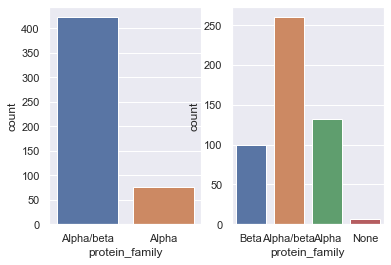

In [121]:
# comparing the number of protein family predicted with the actual one for "dssp"

fig, ax =plt.subplots(1,2)
sns.countplot(x="protein_family", data=df_output_dssp_extraInfo, ax=ax[0])
sns.countplot(x="protein_family", data=df_cath_extraInfo_dssp, ax=ax[1])

<AxesSubplot:xlabel='protein_family', ylabel='count'>

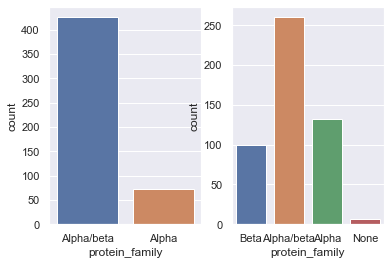

In [140]:
# comparing the number of protein family predicted with the actual one for "stride"

fig, ax =plt.subplots(1,2)
sns.countplot(x="protein_family", data=df_output_stride_extraInfo, ax=ax[0])
sns.countplot(x="protein_family", data=df_cath_extraInfo_stride, ax=ax[1])

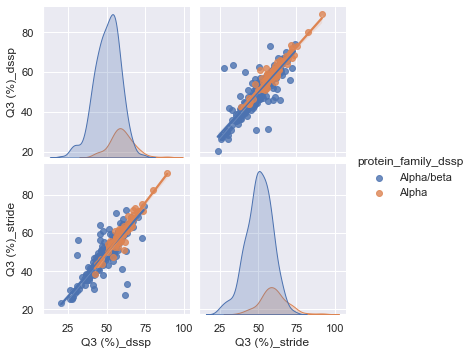

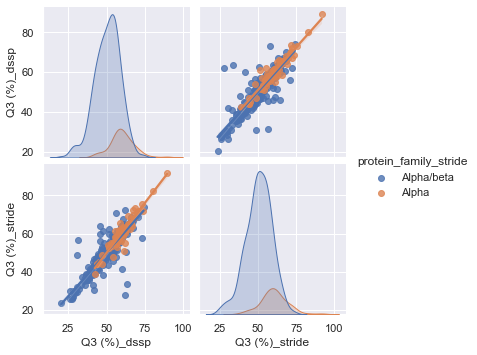

In [122]:
# comparing "Q3" scores of "dssp" and "stride"

df_Q3_hist = df_output_dssp[['Q3 (%)', 'protein_family']].join(df_output_stride[['Q3 (%)', 'protein_family']], lsuffix='_dssp', rsuffix='_stride')
sns.pairplot(df_Q3_hist, hue= 'protein_family_dssp', kind= 'reg')
sns.pairplot(df_Q3_hist, hue= 'protein_family_stride', kind= 'reg')

#######COMMENT###########
# As the figures show, both predictions using "dssp" and/or "stride" have quite similar "Q3" values
# with similar protein family predictions

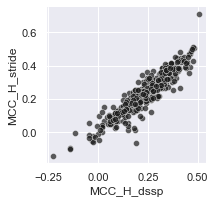

In [179]:
# comparing MCCs for "Helix", "Beta", and "Coil" in the next three cells
arr_MCC_dssp = np.asarray(list_MCC_dssp)
arr_MCC_stride = np.asarray(list_MCC_stride)
df_MCC_dssp = pd.DataFrame(columns= ['MCC_H_dssp', 'MCC_E_dssp', 'MCC_C_dssp'], data= arr_MCC_dssp[:, :])
df_MCC_stride = pd.DataFrame(columns= ['MCC_H_stride', 'MCC_E_stride', 'MCC_C_stride'], data= arr_MCC_stride[:, :])
d = df_MCC_dssp.join(df_MCC_stride)
g = sns.FacetGrid(d)
g.map(sns.scatterplot, "MCC_H_dssp", "MCC_H_stride", alpha=.7, color= 'k')
g.add_legend()

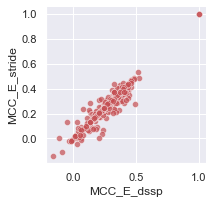

In [171]:
g = sns.FacetGrid(d)
g.map(sns.scatterplot, "MCC_E_dssp", "MCC_E_stride", alpha=.7, color= 'r')
g.add_legend()

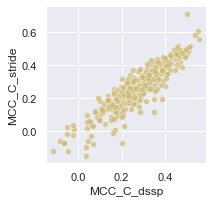

In [174]:
g = sns.FacetGrid(d)
g.map(sns.scatterplot, "MCC_C_dssp", "MCC_C_stride", alpha=.7, color= 'y')
g.add_legend()

#####COMMENT######
#MCCs are quite similar just like Q3